In [1]:
import json, os, sys
%load_ext autoreload
%autoreload 2

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf
from data.loader import load_segmentation
from utils.session_config import setup_gpus
setup_gpus(True, 0.95)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import numpy as np
from matplotlib import pyplot as plt
from pycocotools.coco import COCO
train_ids = np.load("annotations/train_ids.npy")
test_ids = np.load("annotations/val_ids.npy")
coco = COCO("annotations/integrated_annotation.json")

loading annotations into memory...
Done (t=0.84s)
creating index...
index created!


In [7]:
train_ds = load_segmentation(train_ids, coco, "detection")
for patch, mask in train_ds.take(1):
    print(patch.shape)
    print(mask.shape)

(512, 512, 3)
(512, 512)


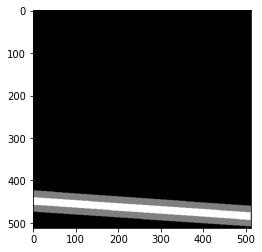

In [8]:
plt.imshow(mask, cmap='gray')

In [11]:
def shape_process(patches, masks):
    masks = tf.where(masks == 100, 1, 0)
    return patches, masks

train_ds = load_segmentation(train_ids, coco, "detection", shuffle=True)
train_ds = train_ds.cache().batch(16).map(shape_process).prefetch(tf.data.experimental.AUTOTUNE)
test_ds = load_segmentation(test_ids, coco, "detection")
test_ds = test_ds.batch(16).map(shape_process)

In [13]:
for patches, masks in train_ds.take(1):
    print(patches.shape)
    print(masks.shape)

(32, 512, 512, 3)
(32, 512, 512)


# 모델 빌드 및 학습

In [16]:
model = tf.keras.models.load_model("models/segmentation.h5")

In [17]:
BCE = tf.keras.losses.BinaryCrossentropy()

@tf.function
def train_step(patches, masks, model, optimizer, train_loss, train_acc):
    with tf.GradientTape() as tape:
        preds = model(patches, training=True)
        loss = BCE(masks,preds)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_acc(labels, preds)
@tf.function
def test_step(patches, masks, model, test_loss, test_acc):
    preds = model(patches, training=False)
    loss = BCE(masks,preds)
    test_loss(loss)
    test_acc(labels, preds)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_acc = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

template = "Epoch {} : detection train loss {:5f}, accuracy {:.3f}, val loss {:5f}, val accuracy {:.3f}"
optimizer= tf.keras.optimizers.Adam(learning_rate=1E-3)
EPOCH = 20

log_dir = "logs/segmentation"
summary_writer = tf.summary.create_file_writer(log_dir)

for epoch in range(1, EPOCH+1): 
    train_loss.reset_states()
    train_acc.reset_states()
    test_loss.reset_states()
    test_acc.reset_states()

    for i, (patches, masks) in enumerate(train_ds):
        train_step(patches, masks, model, optimizer, \
                             train_loss, train_acc)
        print("Epoch : {} train_step : {}".format(epoch, i))
        
    for i, (patches, labels) in enumerate(test_ds):
        test_step(patches, masks, model, test_loss, test_acc)
    print(template.format(epoch,
                      train_loss.result().numpy(),
                      train_acc.result().numpy(),
                     test_loss.result().numpy(),
                     test_acc.result().numpy()))

    with summary_writer.as_default():
        tf.summary.scalar('train_loss', train_loss.result(), step=epoch)
        tf.summary.scalar('train_acc', train_acc.result().numpy(), step=epoch)
        tf.summary.scalar('test_loss', test_loss.result().numpy(), step=epoch)
        tf.summary.scalar('test_acc', test_acc.result().numpy(), step=epoch)

In [ ]:
model.save("checkpoints/segmentation/model.h5")

# 테스트

In [ ]:
model = tf.keras.models.load_modelval_ds = val_ds.map(lambda x: tf.py_function(data_process, [x], [tf.float32, tf.int32])).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(lambda x: tf.py_function(data_process, [x], [tf.float32, tf.int32])).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(lambda x: tf.py_function(data_process, [x], [tf.float32, tf.int32])).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(lambda x: tf.py_function(data_process, [x], [tf.float32, tf.int32])).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.map(lambda x: tf.py_function(data_process, [x], [tf.float32, tf.int32])).prefetch(buffer_size=AUTOTUNE)
("checkpoints/detection/model.h5")

In [ ]:
val_ds = tf.data.Dataset.from_tensor_slices(val_ids).cache().batch(1)
val_ds = val_ds.map(lambda x: tf.py_function(data_process, [x], [tf.float32, tf.int32])).prefetch(buffer_size=AUTOTUNE)

In [ ]:
for img, label in val_ds.take(1):
    print(img.shape)
    print(label)

In [ ]:
fig = plt.figure()

for r in range(5):
    for c in range(4):
        ax = fig.add_subplot(5,4,r*4 + c + 1)
        if r*4+c+1>19:
            break
        ax.imshow((img[r*4+c]+1)/2)

In [ ]:
model(img)